In [0]:
# !pip install fake_useragent
# !pip install -U fake_useragent

Requirement already up-to-date: fake_useragent in /usr/local/lib/python3.6/dist-packages (0.1.11)


In [0]:
import requests
from fake_useragent import UserAgent
import json
from hashlib import md5
import pprint
import time, random
from urllib.request import urlretrieve
from os import listdir
import re

In [0]:
urlretrieve("http://img.xiami.net/lyric/93/1797984893_1511405938425_9965.txt",'test.txt')

('test.txt', <http.client.HTTPMessage at 0x7f4709583b70>)

In [0]:
class Xiami_Scrawl():

  ua = UserAgent(verify_ssl=False)
  DOMAIN = "https://www.xiami.com"
  GENRE_SONG_URL = "/api/genre/getGenreSongs"
  SONG_LYRIC_URL = "/api/song/initialize"
  PROXIES = {
    "http": 'http://31.131.67.14:8080',
    "http": 'http://31.209.96.50:57482',
    "http": 'http://117.240.59.115:36127'
  }

  def __init__(self):
    self.session = requests.Session()
    self.session.get(self.DOMAIN,proxies=self.PROXIES)
    self.headers = {"user-agent": self.ua.random}

  def get_songs_lst(self):
    songs = []
    for i in range(1, 56):
      _q = {"type":2,"orderBy":1,"id":"3341","pagingVO":{"page": i,"pageSize":50}}
      params = self._get_encoded_parameters(self.GENRE_SONG_URL, _q)
      response = self.session.get(url = self.DOMAIN + self.GENRE_SONG_URL, params = params).json()
      if response['code'] == 'SUCCESS':
        songsInPage = response['result']['data']['songs']
        songs += [i['songStringId'] for i in songsInPage]
    return songs

  def get_song_lyric_filepath(self):
    songsId = self.get_songs_lst()
    for i in range(2611, len(songsId)):
      _q = {"songId":songsId[i]}
      params = self._get_encoded_parameters(self.SONG_LYRIC_URL, _q)
      response = self.session.get(url = self.DOMAIN + self.SONG_LYRIC_URL, params = params, proxies=self.PROXIES).json()
      try: 
        response['rgv587_flag']
      except: 
        lyrics = response['result']['data']['songLyric']
        print('获取%d歌词成功'%i)
        for file in lyrics:
          if file['type'] == 1:
            with open('lyrics_url.txt', 'a') as f:
              f.writelines(file['lyricUrl'] + '\n')
      else:
        time.sleep(random.uniform(10, 20))
        print('=============反爬虫等待=============') 

  def _get_encoded_parameters(self, api, _q):
    _q = json.dumps(_q)
    _s = self._get_parameter_s(api, _q)
    return {"_q": _q, "_s": _s}

  def _get_xm_sg_tk(self):
    xm_sg_tk = self.session.cookies.get("xm_sg_tk")
    if xm_sg_tk is None:
      print('xm_sg_tk获取失败')
    else:
      return xm_sg_tk.split("_")[0]

  def _get_parameter_s(self,api,_q):
    _s = self._get_xm_sg_tk() + "_xmMain_" + api + "_" + _q
    return md5(bytes(_s, encoding="utf-8")).hexdigest()

In [0]:
scrawl =  Xiami_Scrawl()

In [0]:
scrawl.get_song_lyric_filepath()

In [0]:
!rm -rf lyrics
!rm -rf lyrics_dataset.txt

In [0]:
!mkdir lyrics

In [0]:
class Process_Data():
  url = 'lyrics_url.txt'
  output_folder = './lyrics/'

  def get_clean_data(self):
    raw_data = self._get_lyrics_from_file()
    pre_clean_data = self._remove_lyrics(raw_data)
    clean_data = self._remove_marks(pre_clean_data)
    self._save_lyrics(clean_data)
  
  def _remove_marks(self, pre_clean_data):
    clean_lyrics = []
    for lyric in pre_clean_data:
      lyric = lyric.replace('\xa0', '')
      lyric = lyric.replace('!', '')
      lyric = lyric.replace('！', '')
      lyric = lyric.replace('？', '')
      lyric = lyric.replace('，', ',')
      lyric = lyric.strip()
      if len(lyric) > 0:
        clean_lyrics.append(lyric)
    return clean_lyrics

  def _remove_lyrics(self, raw_data):
    non_lyric_pattern = "[《》-【】\[\]（）/(HOOK):：.。\(\)(hook)(verse)]+"
    chinese_pattern = u'[\u4e00-\u9fff]'
    return [lyric for lyric in raw_data if re.search(non_lyric_pattern, lyric) == None and re.search(chinese_pattern, lyric) !=None]

  
  def _get_lyrics_from_file(self):
    self._download_lyrics_from_url()
    lyrics = []
    for file in listdir(self.output_folder):
      with open(self.output_folder + file, 'r') as f:
        lyrics += f.readlines()
        f.close()
    return lyrics

  def _download_lyrics_from_url(self):
    with open(self.url, 'r') as f:
      urls = f.readlines()
      f.close()
    for i, url in enumerate(urls):
      try:
        urlretrieve(url, self.output_folder + str(i+1) + '.txt')
      except:
        pass

  def _save_lyrics(self, data):
    with open('lyrics_dataset.txt', 'a') as f:
      for i in data:
        f.writelines(i + '\n')
      f.close()
    print('保存歌词成功！')

In [0]:
process = Process_Data()

In [0]:
process.get_clean_data()

保存歌词成功！


### 词频分析

In [0]:
# !pip install wordcloud

In [0]:
import numpy as np
import jieba
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib
from wordcloud import WordCloud

In [0]:
with open('lyrics_dataset.txt', 'r') as f:
  data = f.readlines()
  f.close()

In [0]:
with open('stopwords.txt', 'r') as f:
  stopwords = f.readlines()
  f.close()

In [0]:
backgroud_Image = np.array(Image.open("bg.jpg"))

In [0]:
jieba_cut = lambda x: " ".join(jieba.cut(x))
words = list(map(jieba_cut, data))
words = " ".join(words)

In [0]:
wc = WordCloud(
    background_color='black',
    mask=backgroud_Image,
    contour_width=3,  
    font_path='chinese.ttf', 
    max_words=2000,  
    stopwords=stopwords, 
    max_font_size=100,
    random_state=1,
    width=1600, height=900, colormap=plt.get_cmap('Pastel2'))
wordcloud = wc.generate(words)

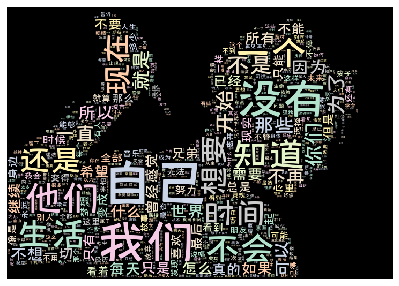

In [0]:
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [0]:
wordcloud.to_file('rap.png')

In [0]:
process_word = WordCloud.process_text(wc,words)
sort = sorted(process_word.items(),key=lambda e:e[1],reverse=True)
print(sort[:50]) 

[('自己', 1243), ('我们', 1024), ('没有', 869), ('他们', 575), ('一个', 527), ('知道', 520), ('生活', 508), ('不会', 489), ('还是', 487), ('时间', 481), ('现在', 471), ('想要', 464), ('不是', 451), ('你们', 418), ('开始', 412), ('为了', 386), ('就是', 347), ('那些', 346), ('一直', 341), ('不再', 324), ('所以', 320), ('因为', 319), ('可以', 318), ('世界', 313), ('不想', 310), ('每天', 294), ('怎么', 291), ('什么', 290), ('如果', 281), ('继续', 278), ('只是', 273), ('需要', 270), ('所有', 264), ('曾经', 255), ('希望', 252), ('感觉', 250), ('一切', 249), ('真的', 247), ('已经', 241), ('只有', 239), ('不要', 239), ('兄弟', 235), ('不能', 232), ('最后', 228), ('总是', 227), ('喜欢', 226), ('只能', 220), ('一起', 216), ('但是', 215), ('现实', 213)]


## 押韵分布

In [0]:
!pip install pypinyin

     |████████████████████████████████| 788kB 4.8MB/s 


In [0]:
from pypinyin.style._utils import get_finals
from pypinyin import lazy_pinyin
import re

In [0]:
def count_rythme(data):
  rhymes = {}
  for line in data:
    word = line.strip()
    chinese_pattern = u'[\u4e00-\u9fff]'
    all_chinese = re.findall(chinese_pattern, line)
    word = ''.join(all_chinese[-2:])
    word_pinyin = lazy_pinyin(word)
    word_rhyme = ''
    for character in word_pinyin:
        rhyme_without_tone = get_finals(character, strict=False)
        word_rhyme += rhyme_without_tone + "'"
    word_rhyme = word_rhyme[0:-1]
    if word_rhyme in rhymes.keys():
      rhymes[word_rhyme] += 1
    else:
      rhymes[word_rhyme] = 1
  return {k: v for k, v in sorted(rhymes.items(), key=lambda item: item[1],reverse=True)}

In [0]:
rhymes_dict = count_rythme(data)

In [0]:
sub_dict = dict(list(rhymes_dict.items())[:10])

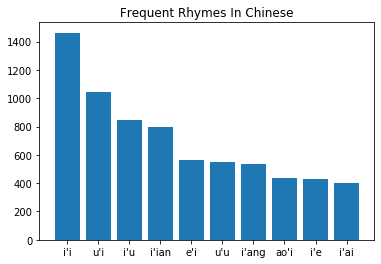

In [0]:
plt.bar(range(len(sub_dict)), list(sub_dict.values()), align='center')
plt.xticks(range(len(sub_dict)), list(sub_dict.keys()))
plt.title('Frequent Rhymes In Chinese')
plt.show()